In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [2]:
with open('data.json', 'r', encoding = 'utf-8') as f:
    data = json.load(f)
    f.close()

In [3]:
nodes = pd.DataFrame(data['nodes']).set_index('id')
ways = pd.DataFrame(data['ways']).set_index('id')
relations = pd.DataFrame(data['relations']).set_index('id')

In [4]:
#obtain public transport routes
#relations are lists of ref, role and type (way/node)
relations.members.iloc[1]

[{'ref': '803437153', 'role': 'house', 'type': 'way'},
 {'ref': '455116744', 'role': 'house', 'type': 'way'},
 {'ref': '455116661', 'role': 'house', 'type': 'way'},
 {'ref': '455116714', 'role': 'house', 'type': 'way'},
 {'ref': '455116458', 'role': 'house', 'type': 'way'},
 {'ref': '41566022', 'role': 'street', 'type': 'way'},
 {'ref': '41566023', 'role': 'street', 'type': 'way'},
 {'ref': '465523912', 'role': 'street', 'type': 'way'}]

In [5]:
relations.tags.iloc[1]

{'name': 'Foo Kim Lin Road', 'type': 'associatedStreet'}

In [6]:
ways.tags.loc['465523912']

{'highway': 'residential',
 'lanes': '1',
 'maxspeed': '40',
 'name': 'Foo Kim Lin Road',
 'oneway': 'yes',
 'surface': 'asphalt',
 'turn:lanes': 'left'}

In [7]:
ways.nodeRefs.loc['465523912']

['509905060', '8276671030', '509905062']

In [8]:
idx = relations.members.explode().index
relation_members = pd.DataFrame(relations.members.explode().tolist())
relation_members['memberOf'] = idx
relation_members.head()

,ref,role,type,memberOf
0,547132201,route,way,272117
1,547132201,route,way,272117
2,160608026,route,way,272117
3,160608025,route,way,272117
4,41425649,route,way,272117


In [9]:
relation_members = relation_members.drop_duplicates().reset_index(drop=True)
unique_roles = relation_members.role.unique()
unique_roles

array(['route', '', 'house', 'street', 'backward', 'forward', 'pitlane',
       'stop', 'stop_inactive', 'admin_centre', 'label', 'outer',
       'platform_entry_only', 'platform_exit_only', 'stop_exit_only',
       'stop_entry_only', 'terminal', 'inner', 'via', 'from', 'to',
       'inactive', 'subarea', 'platform', 'address', 'backward:stop',
       'forward:stop', 'ß', 'Wine Bar', 'Rail Corridor', 'part',
       'outline', 'tomb', 'entrance', 'station', 'device', 'From',
       'subway entrance', 'perimeter', 'buildings', 'force', 'via ',
       'from ', 'contains', 'lta', 'member_state', 'across', 'owner'],
      dtype=object)

In [10]:
COLOR_LABEL = unique_roles
cmap = plt.cm.prism
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
N = len(unique_roles)


In [11]:
colors = [cmaplist[int(i*len(cmaplist)/N)] for i in range(N)]

In [12]:
color_dict = dict(zip(unique_roles, colors))


{''} {'stop'}


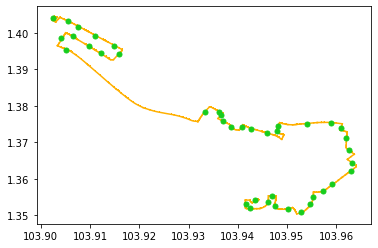

In [13]:
def visualise_relations(r_member):
    
    ls2 = {'way': [], 'landmark': []}
    for i, member in enumerate(r_member):
        if member['type'] == 'way':
            ls = []
            wayref = ways.loc[member['ref']]
            for j, node in enumerate(wayref['nodeRefs']):
                n = nodes.loc[node]
                ls.append((n['lon'], n['lat']))
            ls2['way'].append([np.array(ls), member['role']])
        elif member['type'] == 'node':
            noderef = nodes.loc[member['ref']]
            ls2['landmark'].append([(noderef['lon'], noderef['lat']), member['role']])
    
    return ls2

def create_plot(ls2, fig = None, ax = None):
    ways, nodes = ls2.values()
    label_ways = list(map(lambda x: x[1], ways))
    label_nodes = list(map(lambda x: x[1], nodes))
    print(set(label_ways), set(label_nodes))
    ways = list(map(lambda x: x[0], ways))
    nodes = list(map(lambda x: x[0], nodes))
    
    ways, nodes = np.array(ways), np.array(nodes)
    if ax is None or fig is None:
        fig, ax = plt.subplots()
    for item, label in zip(ways, label_ways):
        ax.plot(item[:,0], item[:, 1], markersize=5, marker = ',', color = color_dict[label])
    for coord, label in zip(nodes, label_nodes):
        ax.plot(coord[0], coord[1], markersize=5, marker = 'o', color = color_dict[label])
        
    return fig, ax
        
test = visualise_relations(relations.members.iloc[16])
fig, ax = create_plot(test)
plt.show()

{''} {'stop'}


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

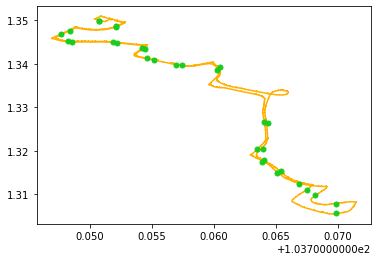

In [14]:
loop = visualise_relations(relations.members.iloc[161])
create_plot(loop)

{'house', 'street'} set()
{'house', 'street'} set()
{'house', 'street'} set()
{'house', 'street'} set()
{'house', 'street'} set()
{'street'} set()
{'house', 'street'} set()
{'house', 'street'} set()
{'', 'pitlane', 'backward', 'forward'} set()
{''} {'stop'}
{''} {'stop', 'stop_inactive'}
{'outer'} {'label', 'admin_centre'}
{''} {'stop'}
{''} {'stop'}
{''} {'stop'}


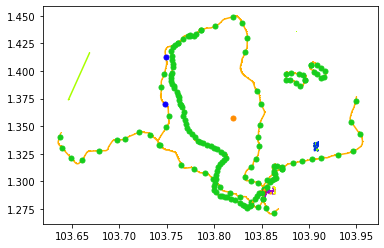

In [303]:
fig, ax = plt.subplots()
for i in range(1,16):
    a = visualise_relations(relations.members.iloc[i])
    fig, ax = create_plot(a, fig, ax)
plt.show()

In [304]:
relation_members.role[relation_members.role == 'from '] = 'from'

In [305]:
relation_members.role[relation_members.role == 'via '] = 'via'

In [306]:
relation_members.role[relation_members.role == 'From'] = 'from'

In [307]:
relation_members = relation_members[~relation_members.role.isin(['owner','member_state','inactive','stop_inactive','subarea'])]

In [256]:
relation_members.role[relation_members.role == 'perimeter'] = 'outer'
relation_members.role[relation_members.role == 'subway entrance'] = 'outline'
#relation_members.role[relation_members.role == 'entrance'] = 'outline'
relation_members.role[relation_members.role == 'buildings'] = 'outline'

C:\Users\ngzhe\anaconda2020\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [280]:
relation_members.role[relation_members.role == 'address'] = 'street'

C:\Users\ngzhe\anaconda2020\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [281]:
relation_members.role.unique()

array(['route', '', 'house', 'street', 'backward', 'forward', 'pitlane',
       'stop', 'admin_centre', 'label', 'outer', 'platform_entry_only',
       'platform_exit_only', 'stop_exit_only', 'stop_entry_only',
       'terminal', 'inner', 'via', 'from', 'to', 'platform',
       'backward:stop', 'forward:stop', 'ß', 'Wine Bar', 'Rail Corridor',
       'part', 'outline', 'tomb', 'station', 'device', 'force',
       'contains', 'lta', 'across'], dtype=object)

In [104]:
unique_roles

array(['route', '', 'house', 'street', 'backward', 'forward', 'pitlane',
       'stop', 'stop_inactive', 'admin_centre', 'label', 'outer',
       'platform_entry_only', 'platform_exit_only', 'stop_exit_only',
       'stop_entry_only', 'terminal', 'inner', 'via', 'from', 'to',
       'inactive', 'subarea', 'platform', 'address', 'backward:stop',
       'forward:stop', 'ß', 'Wine Bar', 'Rail Corridor', 'part',
       'outline', 'tomb', 'entrance', 'station', 'device', 'From',
       'subway entrance', 'perimeter', 'buildings', 'force', 'via ',
       'from ', 'contains', 'lta', 'member_state', 'across', 'owner'],
      dtype=object)

In [333]:
#filter out not needed roles
#owner
#member_state
#From and from  change to from
#via  change to via
#ß (bus) change to ?
#take out inactive and stop_inactive as it does not exist yet
#perimeter and buildings are together and under outline
#subway entrance not in main
#remove subarea
#pitlane is the F1 one, under 421263. consist of forward and backward

"""
(Main Relations)
Buildings:
- street contains some buildings and roads

Transport:
1) Road
    a) Car
    b) Bus
        - via
        - terminal
2) MRT/LRT
    - stop
    
    - 
3) Walk
"""

relation_members.role.value_counts()

                       202421
via                    109341
to                     109109
from                   109100
stop                    25942
house                   10219
outer                    4557
street                   3093
inner                    2266
forward                  1396
backward                 1208
part                      888
device                    406
outline                   181
platform                   86
route                      41
forward:stop               39
platform_entry_only        21
platform_exit_only         21
backward:stop              15
across                      5
station                     4
entrance                    4
pitlane                     3
ß                           3
tomb                        3
lta                         3
Rail Corridor               2
label                       2
stop_entry_only             2
contains                    2
address                     2
subway entrance             1
buildings 

In [420]:
#forward:stop has 4 routes
relation_members[relation_members.role == 'terminal'].tail(50)

,ref,role,type,memberOf
65830,5413582007,terminal,node,1156117


{'', 'perimeter'} set()


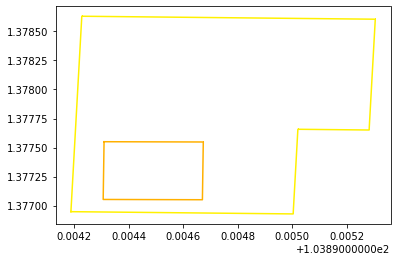

In [510]:
#subway entrance and station
fig, ax = plt.subplots()
stations = relation_members[relation_members.role == 'perimeter']
uniques = stations.memberOf.unique()
for i in range(len(uniques)):
    station = visualise_relations(relations.members.loc[uniques[i]])
    fig, ax = create_plot(station, fig, ax)
plt.show()
#most streets not labelled

{''} {'stop'}


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

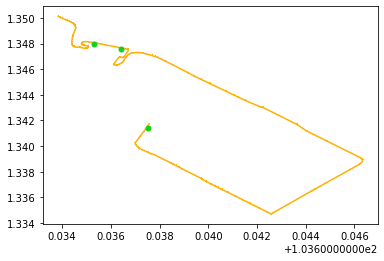

In [419]:
rail_corridor = visualise_relations(relations.members.loc['14165147'])

create_plot(rail_corridor)

In [14]:
#picture rail corridor
relation_members[relation_members.role.isin(['Rail Corridor'])]

,ref,role,type,memberOf
128106,22561114,Rail Corridor,way,3871697
128107,760898053,Rail Corridor,way,3871697


{'', 'Rail Corridor'} set()


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

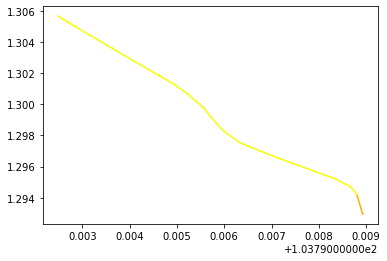

In [417]:
rail_corridor = visualise_relations(relations.members.loc['3871697'])
create_plot(rail_corridor)

In [430]:
def get_routes(relation, kind = 'bus'):
    ls2 = []
    for i,r in relation.iterrows():
        if 'route' in r['tags'].keys():
            if 'network' in r['tags'].keys():
                if r['tags']['route'] == kind and r['tags']['network'] in ['Singapore Rail',
                                                                           'Land Transport Authority',
                                                                          'Circle Line (CCL)/Downtown Line (DTL)',
                                                                           'Downtown Line (DTL)',
                                                                           'East West Line (EWL)/North East Line (NEL)',
                                                                          'MRT',
                                                                           'North South Line (NSL)/Circle Line (CCL)',
                                                                           'Singapore',
                                                                           'SBS']:    
                    ls = []
                    for member in r['members']:
                        if member['type'] == 'node' and member['role'] != 'stop_inactive':
                            ls.append(member['ref'])
                    ls2.append(ls)
    return ls2

#get the operating routes only
bus_routes = get_routes(relations, 'bus')
train_routes = get_routes(relations, 'subway')
#rail_routes = get_routes(relations, 'railway')
monorail_routes = get_routes(relations, 'monorail')

In [431]:
bus_stops = set(list(itertools.chain.from_iterable(bus_routes)))
train_stops = set(list(itertools.chain.from_iterable(train_routes)))
monorail_stops = set(list(itertools.chain.from_iterable(monorail_routes)))

#in operation
print(len(bus_stops)) #5056 bus stops ~ 5049 in July 2021
print(len(train_stops)) #196 train stations, 126 left
print(len(monorail_stops)) #56 monorail stations, 15 repeated, so 41 left

5056
196
56


In [507]:
def get_nearest_nodes(coords):
    """
    returns a node reference number
    next time can consider building a K-D tree
    for now just brute force aka nearest neighbour search
    """
    lat, lon = coords
    subset = nodes.copy()
    for i in range(40):
        if len(subset) < 4:
            break
        subset = subset[(abs(subset.lat - lat) < 2**(-i)) & (abs(subset.lon - lon < 2**(-i)))]
        
    node = subset.reset_index()['id']
    return node

In [509]:
relation_members

,ref,role,type,memberOf
0,547132201,route,way,272117
1,160608026,route,way,272117
2,160608025,route,way,272117
3,41425649,route,way,272117
4,41425653,route,way,272117
...,...,...,...,...
580564,4593504144,via,node,14448511
580565,121881092,to,way,14448511
580566,1085537554,from,way,14448512
580567,4593504144,via,node,14448512


In [508]:
get_nearest_nodes([1.290270, 103.851959])

0    4500179904
Name: id, dtype: object

In [ ]:
def get_path(start, end, via):
    #find nearest nodes to the start and end
    #this is done by walking
    start_nearest = get_nearest_node(start)
    end_nearest = get_nearest_node(end)
    via_nearest = get_nearest_node(via)
    
    #perform path search along the relations
    nodes = list(start_nearest)
    
    #find possible paths
    possible_paths = relation_members.memberOf[relation_members.ref.isin(nodes)]
    
    #do a breadth first search
    #create a graph of all possible paths
    
    """
    hierarchy of transport (speed)
    1 - walk/cycle - on paths
    2 - bus - on specific roads
    3 - mrt - on mrt
    4 - drive - on roads (not advised)
    
    pseudocode:
    generate network graphs of the above 4 paths
    perform a search:
    go to a higher hierarchy wherever possible to complete large parts of the journey(greedy)
    lower the hierarchy for last mile journeys
    """
    return
    

In [ ]:
"""
Data Structures

Node:
(Bus Stop, WayPoints is a Node)

Edge: is node A connected to node B?
start, end, distance
(Ways)

Path:
(Walking Path, Road inherits from Path)
A series of nodes and edges

Route: a set Path and direction, with a schedule
(Bus Route, Itinerary inherits from Route)

Graph:
a collection of nodes, edges, set paths and routes 
(MRT system, bus system is a network)
Functions:
- search for a path with Contraction Hierarchies

contraction hierarchy
"""

In [ ]:
class Node:
    """
    A point representing a landmark
    """
    def __init__(self, id_, lat, lon):
        self.id = id_
        self.lat = lat
        self.lon = lon
        
class Edge:
    """
    Adjacent connected nodes
    """
    def __init__(self, start, end):
        """
        start, end: Node objects
        for bidirectional, create 2 edges
        
        """
        self.start = start
        self.next = end
        self.distance = distance_function(start, end)
        self.name = name
        
class Path:
    """
    Consecutive edges
    """
    def __init__(self, edges, name):
        self.edges = edges
        self.name = name
        
    def isIntersection(self, other):
        pass
    
class Route(Path):
    def __init__(self):
        super(Path, self).__init__(edges, name)
        
class Graph:
    def __init__(self)

In [ ]:
def construct_network(data):
    #data can be road, mrt or pedestrian paths
    #returns a Graph object
    #edges
    g = Graph()
    
    return g


    